In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil.relativedelta

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# load symbols

In [2]:
filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/data/"

In [3]:
df_symbols = pd.read_pickle(filepath + "symbols.pd")

In [4]:
df_symbols["Symbol"] = df_symbols["Symbol"].astype(str).apply(lambda sym: sym.lower())

In [5]:
df_symbols.head()

,index,Symbol,Description,STOCK_EXCHANGE
0,0,aaa,First Priority Clo Bond ETF,AMEX
1,1,aaau,GS Physical Gold ETF,AMEX
2,2,aamc,Altisource Asset,AMEX
3,3,aau,Almaden Minerals,AMEX
4,4,abeq,Absolute Core Strategy ETF,AMEX


# load reddit data

In [6]:
from common.tools import Reddit
import os

In [7]:
r = Reddit()

In [8]:
cols = ["id", "created_at", "title", "selftext", "score", "permalink", "num_comments", "ups", "upvote_ratio", "total_awards_received"]

subreddit = r.subreddits[-2]
subreddit

'wallstreetbets'

In [9]:
#df = pd.read_pickle(filepath + "wallstreetbets.pd")
df = r.load_raw_text(os.path.join(r.filepath, subreddit, "new"), cols)

In [10]:
df["has_selftext"] = list(map(int, df.selftext.str.len() != 0))
df["downs"] = df[["ups", "upvote_ratio"]].apply(lambda row: row[0]/row[1] - row[0], axis=1)

In [11]:
df.head()

,id,created_at,title,selftext,score,permalink,num_comments,ups,upvote_ratio,total_awards_received,has_selftext,downs
0,t3_pazmes,2021-08-25,$BB BlackBerry the sleeping giant (Potential $...,**My fellow APES** 🐵 **just remember that DIAM...,1082.0,/r/wallstreetbets/comments/pazmes/bb_blackberr...,188.0,1082.0,0.87,29.0,1,161.678161
1,t3_pb21jz,2021-08-25,FINRA VIOLATION - JP Morgan didn't enforce cov...,[FINRA violation pdf](https://www.finra.org/si...,102.0,/r/wallstreetbets/comments/pb21jz/finra_violat...,28.0,102.0,0.97,0.0,1,3.154639
2,t3_pb1v1v,2021-08-25,After being in hibernation since 2010 I think ...,,1.0,/r/wallstreetbets/comments/pb1v1v/after_being_...,31.0,1.0,0.51,0.0,0,0.960784
3,t3_pb1sa3,2021-08-25,Urban Outfitters $URBN Releases Quarterly Earn...,RECORD EARNINGS this quarter! Back when May 25...,4.0,/r/wallstreetbets/comments/pb1sa3/urban_outfit...,11.0,4.0,0.61,0.0,1,2.557377
4,t3_pb1iqr,2021-08-25,600k worth of CLNE YOLO,,84.0,/r/wallstreetbets/comments/pb1iqr/600k_worth_o...,37.0,84.0,0.81,2.0,0,19.703704


In [12]:
df.shape

(4220, 12)

# text pre-processing

## lower and remove punctuation etc.

In [13]:
import re
import string
import emoji

In [14]:
def get_emojis(text):
    return {c for c in text if c in emoji.UNICODE_EMOJI['en']}

In [15]:
def cleaning(text):
    text = text.lower()
    text = re.sub("\[.*\]", "", text)
    text = re.sub("\(.*\)", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub("\s{2}", " ", text)
    text = text.encode("ascii", "ignore").decode("ascii") # removing emojis
    return text

In [16]:
df["title_clean"] = df.title.apply(cleaning)
df["text_clean"] = df.apply(lambda row: cleaning(row["title"] + " " + row["selftext"]), axis=1)
df["emojis"] = df.apply(lambda row: get_emojis(row["title"] + " " + row["selftext"]), axis=1)

## remove daily threads

In [17]:
df = df[~df.title_clean.str.contains("daily.*thread")]

## remove stop words and tokenize

In [18]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [19]:
stop_words = set(stopwords.words("english"))
stop_words.add("yolo")

In [20]:
len(stop_words & set(df_symbols["Symbol"].tolist()))

54

In [21]:
df["title_tokens"] = df.title_clean.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])
df["text_tokens"] = df.text_clean.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])

## filter stocks

In [22]:
from collections import Counter

In [23]:
symbols = set(df_symbols["Symbol"].tolist()) - set(words.words())
symbols.add("wish")
symbols.remove("yolo")
symbols.remove("app")
len(symbols)

65578

In [24]:
df["title_symbols"] = df.title_tokens.apply(lambda tokens: [token for token in tokens if token in symbols])
df["text_symbols"] = df.text_tokens.apply(lambda tokens: [token for token in tokens if token in symbols])

In [25]:
df["title_symbols"] = df.title_symbols.apply(Counter)
df["text_symbols"] = df.text_symbols.apply(Counter)

In [26]:
def remove_stocks(row, col):
    title, stocks = row[col], row["title_symbols"].keys()
    for stock in stocks:
        title = title.replace(stock, "")
    return title

In [27]:
df["title_clean_no_stocks"] = df.apply(lambda row: remove_stocks(row, "title_clean"), axis=1)

In [28]:
df["text_clean_no_stocks"] = df.apply(lambda row: remove_stocks(row, "text_clean"), axis=1)

In [29]:
df["title_tokens_clean"] = df.title_clean_no_stocks.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])
df["text_tokens_clean"] = df.text_clean_no_stocks.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])

## stemming

In [30]:
sno = nltk.stem.SnowballStemmer("english")

In [31]:
df["title_tokens"] = df.title_tokens.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["text_tokens"] = df.text_tokens.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["title_tokens_clean"] = df.title_tokens_clean.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["text_tokens_clean"] = df.text_tokens_clean.apply(lambda tokens: [sno.stem(token) for token in tokens])

## lemmatization

In [32]:
lem = nltk.stem.WordNetLemmatizer()

In [33]:
df["title_tokens"] = df.title_tokens.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["text_tokens"] = df.text_tokens.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["title_tokens_clean"] = df.title_tokens_clean.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["text_tokens_clean"] = df.text_tokens_clean.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])

# Sentiment Analysis

In [34]:
# take only entires where we have some symbols
df_sa = df[df.title_symbols.apply(len) > 0]

## lexicon-based
__Different lexicons__:
* AFINN
* Bing Liu's
* MPQA subjectivity
* SentiWordNet
* VADER
* TextBlob

### AFINN

In [35]:
from afinn import Afinn

In [36]:
af = Afinn()

In [37]:
df_sa["AFINN_polarity"] = df_sa.text_clean.apply(lambda text: af.score(text))

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Bing Liu's

In [38]:
nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [39]:
pos = set(opinion_lexicon.positive())
neg = set(opinion_lexicon.negative())

In [40]:
df_sa["Bing_Liu_polarity"] = df_sa.text_tokens.apply(lambda tokens: sum(1 if token in pos else -1 if token in neg else 0 for token in tokens))

### Vader

In [41]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
sid = SentimentIntensityAnalyzer()

In [43]:
df_sa["VADER_polarity"] = df_sa.text_clean.apply(lambda text: sid.polarity_scores(text)["compound"])

### TextBlob

In [44]:
from textblob import TextBlob

In [45]:
df_sa["TextBlob_polarity"] = df_sa.text_clean.apply(lambda text: TextBlob(text).polarity)

### Word Embedding (CBOW)

In [46]:
from gensim.models import word2vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [47]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.loss_history = list()

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.loss_history.append(loss)
            #print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            self.loss_history.append(loss- self.loss_previous_step)
            #print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

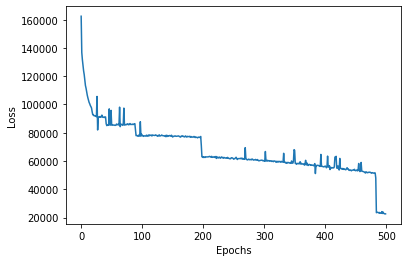

In [48]:
n_epochs = 500
c = callback()

cbow_model = word2vec.Word2Vec(
    df_sa.text_tokens,
    window=2,
    min_count=50,
    epochs=n_epochs,
    seed=99,
    compute_loss=True,
    callbacks=[c]
)

plt.plot(c.loss_history)
#plt.xticks(list(range(n_epochs)))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [49]:
cbow_model.wv.most_similar(positive="buy")

[('sell', 0.5864537954330444),
 ('load', 0.405522882938385),
 ('hold', 0.3981756269931793),
 ('call', 0.36973777413368225),
 ('itm', 0.35978636145591736),
 ('put', 0.35197609663009644),
 ('dip', 0.34997254610061646),
 ('ride', 0.3376378118991852),
 ('pick', 0.3146008253097534),
 ('know', 0.3045772612094879)]

In [50]:
cbow_model.wv.similarity(w1="buy", w2="sell")

0.58645374

In [51]:
def word_similarity(model, w1:str, w2:str):
    """similarity between two words"""
    try:
        return model.wv.similarity(w1=w1, w2=w2)
    except:
        return 0

In [52]:
df_sa["cbow_buy_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(cbow_model, "buy", token) for token in tokens] + [0]))
df_sa["cbow_sell_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(cbow_model, "sell", token) for token in tokens] + [0]))

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Word Embedding (SKIP-GRAM)

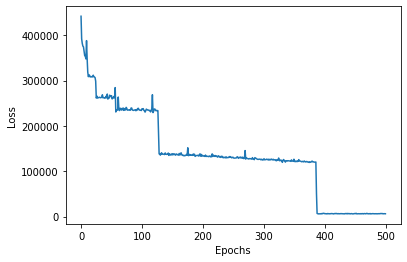

In [53]:
n_epochs = 500
c = callback()

sg_model = word2vec.Word2Vec(
    df_sa.text_tokens,
    window=2,
    min_count=50,
    epochs=n_epochs,
    sg=1,
    seed=99,
    compute_loss=True,
    callbacks=[c]
)

plt.plot(c.loss_history)
#plt.xticks(list(range(n_epochs)))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [54]:
sg_model.wv.most_similar(positive="buy")

[('sell', 0.6690005660057068),
 ('hold', 0.4901556074619293),
 ('call', 0.45908159017562866),
 ('put', 0.44604355096817017),
 ('share', 0.4328191876411438),
 ('dip', 0.4277474284172058),
 ('stock', 0.42269012331962585),
 ('purchas', 0.4221177101135254),
 ('know', 0.4180748164653778),
 ('like', 0.41068413853645325)]

In [55]:
df_sa["sg_buy_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(sg_model, "buy", token) for token in tokens] + [0]))
df_sa["sg_sell_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(sg_model, "sell", token) for token in tokens] + [0]))

### Emoji

In [56]:
#python -m pip install https://github.com/FintelLabs/emosent-py/archive/e5788e73e88f691b44fd5f6eda72187b559d99f2.tar.gz
from emosent import get_emoji_sentiment_rank

In [57]:
def get_emoji_score(emoji):
    try:
        return get_emoji_sentiment_rank(emoji)["sentiment_score"]
    except:
        return 0

In [58]:
df_sa["emoji_polarity"] = df_sa.emojis.apply(lambda emojis: max([get_emoji_score(emoji) for emoji in emojis] + [0]))

### Comparison

In [59]:
df_sa[["text_clean","AFINN_polarity", "Bing_Liu_polarity", "VADER_polarity", "TextBlob_polarity", "cbow_buy_polarity", "cbow_sell_polarity", "sg_buy_polarity", "sg_sell_polarity", "emoji_polarity"]].head(50)

,text_clean,AFINN_polarity,Bing_Liu_polarity,VADER_polarity,TextBlob_polarity,cbow_buy_polarity,cbow_sell_polarity,sg_buy_polarity,sg_sell_polarity,emoji_polarity
0,bb blackberry the sleeping giant my fellow ap...,30.0,14,0.9982,0.251447,0.586454,1.000000,0.669001,1.000000,0.621
1,finra violation jp morgan didnt enforce coveri...,-30.0,-12,-0.9835,-0.098769,1.000000,0.586454,1.000000,0.669001,0.000
3,urban outfitters urbn releases quarterly earni...,0.0,0,-0.2023,-0.033333,0.290377,0.283887,0.432819,0.411581,0.000
4,worth of clne yolo,2.0,1,0.4588,0.300000,0.095611,0.101577,0.150936,0.140760,0.000
6,gme gang to the moon,0.0,0,0.0000,0.000000,0.043039,0.000000,0.174183,0.151735,0.000
8,gme baby,0.0,0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
9,to the moon lfg hodl,0.0,0,0.0000,0.000000,0.043039,0.000000,0.174183,0.151735,0.000
17,light work on panw overnight,0.0,1,0.0000,0.400000,0.000000,0.109719,0.116134,0.243620,0.000
19,bb has the potential to make some serious move...,-5.0,2,-0.1851,0.016095,0.586454,1.000000,0.669001,1.000000,0.000
21,im up get the bottles out bb,0.0,0,0.0000,0.000000,0.294367,0.239921,0.392485,0.482100,0.000


# Latent Dirichlet Allocation (LDA)

In [62]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

In [63]:
df_sa["title_bigrams"] = df_sa.title_tokens_clean.apply(lambda t: ["_".join(bigram) for bigram in nltk.bigrams(t)])

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [64]:
id2word = corpora.Dictionary(df_sa.title_tokens_clean)
#id2word = corpora.Dictionary(df_sa.title_bigrams)

1504 | INFO | adding document #0 to Dictionary(0 unique tokens: [])
1504 | INFO | built Dictionary(2620 unique tokens: ['blackberri', 'giant', 'sleep', 'bag', 'compet']...) from 2048 documents (total 9649 corpus positions)
1504 | INFO | Dictionary lifecycle event {'msg': "built Dictionary(2620 unique tokens: ['blackberri', 'giant', 'sleep', 'bag', 'compet']...) from 2048 documents (total 9649 corpus positions)", 'datetime': '2021-08-25T20:46:22.330642', 'gensim': '4.0.1', 'python': '3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [65]:
corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_tokens_clean]
#corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_bigrams]

## hyperparameter tuning

In [108]:
df_sa.shape

(2048, 33)

In [66]:
def tuning_lda_model(n_topics, alpha="symmetric", eta=None):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=n_topics,
        random_state=100,
        update_every=1,
        chunksize=1500,
        passes=10,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
    )
    return lda_model

In [83]:
#%matplotlib qt

In [102]:
if False:
    # Topic parameter
    topics = range(2,80)

    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.05))
    alpha.append('symmetric')
    alpha.append('asymmetric')

    # Beta parameter
    eta = list(np.arange(0.1, 1, 0.05))
    eta.append('symmetric')
    
    previous_score = 0
    topic_scores = list()
    for n_topics in topics:
        lda_model = tuning_lda_model(n_topics)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_n_topics = n_topics
        topic_scores.append(score)
        print(n_topics, score)
    
    plt.plot(topic_scores)
    plt.xticks(range(len(topics)), topics, rotation=-45)
    plt.xlabel("Topics")
    plt.ylabel("Coherence_score")
    plt.show()
        
    previous_score = 0
    alpha_scores = list()
    for a in alpha:
        lda_model = tuning_lda_model(best_n_topics, a)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_alpha = a
        alpha_scores.append(score)
        print(a, score)
        
    plt.plot(alpha_scores)
    plt.xticks(range(len(alpha)), [round(a, 2) if type(a) == np.float64 else a for a in alpha], rotation=-45)
    plt.xlabel("Alpha")
    plt.ylabel("Coherence_score")
    plt.show()
        
    previous_score = 0
    eta_scores = list()
    for e in eta:
        lda_model = tuning_lda_model(n_topics, best_alpha, e)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_eta = e
        eta_scores.append(score)
        print(e, score)
    
    plt.plot(eta_scores)
    plt.xticks(range(len(eta)), [round(e, 2) if type(e) == np.float64 else e for e in eta], rotation=-45)
    plt.xlabel("Eta")
    plt.ylabel("Coherence_score")
    plt.show()
    
    print(best_n_topics, best_alpha, best_eta)

# model

In [107]:
if True:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=best_n_topics,
        random_state=100,
        update_every=1,
        chunksize=1500,
        passes=10,
        alpha=best_alpha,
        eta=best_eta,
        per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
    print(coherence_model_lda.get_coherence())

0.48622420280825857


In [ ]:
# safe model
if False:
    filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/models/lda_model.model"
    lda_model.save(filepath)

In [ ]:
# load model
if True:
    filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/models/lda_model.model"
    lda_model = gensim.models.ldamodel.LdaModel.load(filepath)
        
    id2word = lda_model.id2word
    corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_tokens_clean]
    #lda_model[corpus]
    
    lda_model.update(corpus)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
    print(coherence_model_lda.get_coherence())

## evaluation

__interesting topics:__
* 3 - buy
* 8 - earn
* 12 - save
* 13 - bought
* 15 - sell
* 16 - rise
* 17 - moon
* 28 - drop

In [ ]:
topics_definition = {
    "positiv": [3,5,10,11,12,14,23],
    "negativ": [6,22],
}

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

## Apply LDA model on DataFrame

In [ ]:
def lda_score_threshold(tokens, threshold=0.05):
    bow = id2word.doc2bow(tokens)
    return [topic for topic, score in lda_model[bow][0] if score > threshold]

In [ ]:
df_sa["topics"] = df_sa.title_tokens_clean.apply(lda_score_threshold)

In [ ]:
print("df_size:", df_sa.shape[0], "\ndf_no_topic_found:", sum(df_sa.topics.str.len() == 0), "\ndf_topics_found:", sum(df_sa.topics.str.len() >= 1))

## Results

### Top 3 stock symbols per day

In [ ]:
polarity_cols = df_sa.columns[df_sa.columns.str.contains(r"polarity$")].tolist()
polarity_cols

In [ ]:
stock_polarity_cols = [polarity + "_stock_score" for polarity in polarity_cols]
# score is based on all symbols per day, not a subset (e.g. "SPCE" got 50 threads for one day, but only 20 are in the relevant ones -> but the calculation is done on the 50)
series = df_sa[["title_symbols"] + polarity_cols].apply(lambda row: [Counter({symbol: polarity for symbol in row["title_symbols"]}) for polarity in row[polarity_cols]], axis=1)
df_sa[stock_polarity_cols] = pd.DataFrame(series.tolist(), index=series.index)

In [ ]:
df_sa["thread_score_per_stock"] = df_sa[["title_symbols", "score"]].apply(lambda row: Counter({symbol: row["score"] for symbol in row["title_symbols"].keys()}), axis=1)

In [ ]:
def update_counters(series):
    total = Counter()
    for counter in series.tolist():
        if not type(counter) is Counter:
            continue
        total.update(counter)
    return total

In [ ]:
df_results = df_sa.groupby("created_at")[["title_symbols", "thread_score_per_stock"] + stock_polarity_cols].agg(update_counters)
df_results["most_common_symbols"] = df_results.title_symbols.apply(lambda counter: counter.most_common(3))
df_results["unique_symbol_count"] = df_results.title_symbols.str.len()

df_results["most_common_thread_score"] = df_results.thread_score_per_stock.apply(lambda counter: [(stock, value) for stock, value in counter.most_common(3) if value > 0])

for col in stock_polarity_cols:
    df_results["most_common_" + col] = df_results[col].apply(lambda counter: [(stock, value) for stock, value in counter.most_common(3) if value > 0])
    df_results["least_common_" + col] = df_results[col].apply(lambda counter: [(stock, value) for stock, value in counter.most_common()[::-1] if value < 0][0:3])

df_results.drop(columns=["title_symbols", "thread_score_per_stock", "least_common_buy_polarity_stock_score", "least_common_sell_polarity_stock_score", "least_common_emoji_polarity_stock_score"] + stock_polarity_cols, inplace=True)
df_results.head(100).style

## LDA results

In [ ]:
df_lda_results = df_sa[["created_at", "title", "score", "AFINN_polarity", "Bing_Liu_polarity", "VADER_polarity", "TextBlob_polarity", "buy_polarity", "sell_polarity", "emoji_polarity", "has_selftext", "topics", "title_symbols", "num_comments", "ups", "downs", "upvote_ratio", "total_awards_received"]].copy()

### No topics found

In [ ]:
df_lda_results[df_lda_results.topics.str.len() == 0].head(200).style

### relevant topics found

In [ ]:
flatten = lambda nested_list: [elm for sublist in nested_list for elm in sublist]

In [ ]:
relevant_topics = flatten(topics_definition.values())

In [ ]:
mask = df_lda_results.topics.apply(lambda topics: len(set(topics) & set(relevant_topics)) >= 1)
print(sum(mask))

In [ ]:
df_lda_results[mask].head(200).style

In [ ]:
df_results2 = df_results.copy()
df_results2["title_symbols_relevant"] = df_lda_results[mask].groupby("created_at")[["title_symbols"]].apply(lambda c: c.sum())
df_results2["most_common_symbols_relevant"] = df_results2.title_symbols_relevant.apply(lambda counter: counter.most_common(3) if type(counter) == Counter else float('nan'))
df_results2["unique_symbol_count_relevant"] = df_results2.title_symbols_relevant.str.len()
df_results2["unique_symbol_count_relevant"] = df_results2.unique_symbol_count_relevant.fillna(0).astype(int)
df_results2.drop(columns="title_symbols_relevant", inplace=True)
df_results2.head(100).style

### check topics of specific stock symbols

In [ ]:
Counter(flatten(df_sa[df_sa.title_symbols.apply(lambda c: "spce" in c)].topics.tolist())).most_common(5)

# Read Stock Data

In [ ]:
import yfinance as yf

## Feature collection

In [ ]:
df_lda_results.columns

In [ ]:
# add topics
_df = df_lda_results.explode("topics")
_df["value"] = ~_df.topics.isna()
_df = _df.pivot_table("value", _df.index, "topics").fillna(0).add_prefix("topic_count_")
df_features = pd.merge(df_lda_results, _df, left_index=True, right_index=True)

# unigram
#id2word = corpora.Dictionary(df_sa.text_tokens_clean)
#corpus = [dict(id2word.doc2bow(tokens)) for tokens in df_sa.text_tokens_clean]
# bigram
#df_sa["text_tokens_clean_bigram"] = df_sa.text_tokens_clean.apply(lambda t: ["_".join(bigram) for bigram in nltk.bigrams(t)])
#id2word = corpora.Dictionary(df_sa.text_tokens_clean_bigram)
#corpus = [dict(id2word.doc2bow(tokens)) for tokens in df_sa.text_tokens_clean_bigram]
# add word ids
#_df = pd.DataFrame(corpus).fillna(0)
#df_features = pd.concat([df_features, _df], axis=1)

# add stocks
df_features = df_features.explode("title_symbols").rename(columns={"title_symbols": "stock"})
df_features["stock_thread_count"] = 1
df_features.drop(columns=["topics", "title"], inplace=True)

_stock_data = yf.download(df_features.stock.unique().tolist(), start=df_features.created_at.min(), end=df_features.created_at.max())
df_features = df_features.groupby(["stock", "created_at"], as_index=False).sum()

# join stock data
#_df = _stock_data.Close.pct_change().reset_index()
_df = _stock_data[["Open", "Close"]].apply(lambda row: (row["Close"]-row["Open"])/row["Open"]*100, axis=1).reset_index()
_df["Date"] =_df.Date.apply(lambda ts: ts.to_pydatetime().date())
df_features = pd.merge(df_features, _df, left_on="created_at", right_on="Date")

# select labels
df_features["value_change"] = df_features.apply(lambda row: row[row["stock"].upper()], axis=1).fillna(0)
df_features = df_features.drop(columns=_df.columns).sort_values("created_at")

# round labels
print("\nmean value change:", df_features.value_change.abs().mean())
print("median value change:", df_features.value_change.abs().median())
# 1=buy; 0=hold; -1=sell
#df_features["labels"] = df_features.value_change.apply(lambda x: 1 if x > .01 else -1 if x < -.01 else 0)
df_features["labels"] = df_features.value_change.apply(lambda x: 1 if x > 2 else -1 if x < -2 else 0)
df_features = df_features.reset_index(drop=True)

print()

df_features.labels.value_counts()

In [ ]:
df_features.shape

In [ ]:
df_features.has_selftext.unique()

In [ ]:
df_features.columns[:20]

In [ ]:
df_features.head(50)

# Classifiers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
_df = df_features.copy()
_df = _df.drop(columns=["stock", "created_at", "close_label"])

labels = _df["labels"]
features= _df.drop("labels", axis = 1)
feature_list = list(features.columns)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

### Train model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
model_rf = RandomForestClassifier(n_estimators = 100,
                                  random_state = 2,
                                 )
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)
#errors = abs(predictions - test_labels)
#print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
print('Training set metrics:')
y_pred = model_rf.predict(X_train)
print('Accuracy:', accuracy_score(y_train, y_pred))
print('Precision:', precision_score(y_train, y_pred, average='micro'))
print('Recall:', recall_score(y_train, y_pred, average='micro'))

print('Test set metrics:')
y_pred = model_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:', recall_score(y_test, y_pred, average='micro'))

In [ ]:
col_sorted_by_importance=model_rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':features.columns[col_sorted_by_importance],
    'imps':model_rf.feature_importances_[col_sorted_by_importance]
})

px.bar(feat_imp, x='cols', y='imps')

In [ ]:
confusion_matrix(y_test, y_pred)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

In [ ]:
y_pred = model_nb.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [ ]:
ac

## Neural Network
* testing with labels 1,0,-1 (3 output layer with a softmax)
* testing with 1 output layer to predict (the % increase/decrease)

## Results
* random forest: 0.34 -> 0.39 -> 0.41
* naive bayes: 0.39
* neural network:

In [ ]:
stock_data = yf.download(other_stocks, start=df_results2.index.min(), end=df_results2.index.max())

In [ ]:
other_stocks.remove("WINS")

In [ ]:
test2 = stock_data.Close.pct_change()

In [ ]:
import plotly.express as px

fig = px.line(test2)
fig.show()

In [ ]:
gt3_stock_threads = df_results2.most_common_symbols_relevant.apply(lambda c: [stock for stock, count in c if count >= 3] if type(c) is list else list())

In [ ]:
stock_data = yf.download(top_stocks, start=df_results2.index.min(), end=df_results2.index.max())

In [ ]:
test = stock_data.Close.pct_change()

In [ ]:
test

In [ ]:
import plotly.express as px

fig = px.line(test)
for key, value in gt3_stock_threads.to_dict().items():
    if not value:
        continue
    fig.add_vline(x=key, line_width=2, line_dash="dash")
    print(key, value)
fig.show()

In [ ]:
end_date = datetime.datetime.now()
start_date = end_date - dateutil.relativedelta.relativedelta(months=18)

In [ ]:
stocks_per_day = df_results2.most_common_symbols.apply(lambda stocks: stocks[0][0]).str.upper().tolist()
top_stocks = list(set(stocks_per_day))
#top_stocks

In [ ]:
other_stocks = [stock.upper() for stock, counts in update_counters(df_sa.title_symbols).most_common(50)]
other_stocks.remove("LFG")
other_stocks.remove("EV")
#other_stocks

In [ ]:
#stock_data = yf.download(other_stocks, start=start_date, end=end_date)
stock_data = yf.download(top_stocks, start=start_date, end=end_date)

## Candlestick Charts

In [ ]:
import plotly.graph_objects as go

In [ ]:
def candlestick(symbols):
    if isinstance(symbols, str):
        symbols = [symbols]
    
    fig = go.Figure(data=[go.Candlestick(
        x=stock_data.index,
        open=stock_data.Open[symbol],
        high=stock_data.High[symbol],
        low=stock_data.Low[symbol],
        close=stock_data.Close[symbol],
        name=symbol
    ) for symbol in symbols])
    fig.update_layout(
        title=", ".join(symbols),
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Stocks",
    )
    fig.show()

In [ ]:
candlestick(unique_stocks[0:2])

## Line Charts

In [ ]:
import plotly.express as px

In [ ]:
def line(symbols):
    fig = px.line(stock_data.Open[symbols])
    fig.show()

In [ ]:
line(unique_stocks)

## OHLC Charts

In [ ]:
def ohlc(symbols):
    if isinstance(symbols, str):
        symbols = [symbols]
        
    fig = go.Figure(data=[go.Ohlc(
        x=stock_data.index,
        open=stock_data.Open[symbol],
        high=stock_data.High[symbol],
        low=stock_data.Low[symbol],
        close=stock_data.Close[symbol],
        name=symbol
    ) for symbol in symbols])
    fig.update_layout(
        title=", ".join(symbols),
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Stocks",
    )
    fig.show()

In [ ]:
ohlc(unique_stocks[0:2])

In [ ]:
#s.actions

In [ ]:
#s.options

In [ ]:
#s.calendar

In [ ]:
#s.recommendations

In [ ]:
#s.sustainability

In [ ]:
#s.info

# Ideas for further progression

* process emojis
* Poincaré embeddings (https://arxiv.org/pdf/1705.08039.pdf)
* process gifs/videos/links/images
* more data

# Problems
* classifier isn't a good solution
    * every stock with 1% increase/decrease gets labeled as buy/sell
    * use a model which predicts the increase/decrease amount